# **GR5242 HW04 Problem 4: Transfer learning with MobileNets**



**For coding questions, look for filling in ########## Your code here ##########; for reflection questions, write down your answers in the "Your Answer:" text block.**

There are many examples of external links to documentation. If you see reference to a `pytorch` or similar object, try hovering over the word to see if documentation is linked.

## Description:
In this homework, you will practice (1) going over the full procedure of training a neural network and (2) extending your knowledge on TF2, by implementing a transfer learning task. You will incorporate the existing [MobileNets](https://arxiv.org/abs/1704.04861) to your own network structure and to classify some new categories of images. Building and fitting the network from scratch is expensive and beyond the scope of this assignment, so you will load the MobileNets model which was pre-trained on the imagenet dataset. The version of MobileNet we're using is V2, which is a family of neural network architectures for efficient on-device image classification and related tasks.

As a general advice, you can refer to the official documentations for more info if necessary.



**Import modules for later usage.**

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np


print("PyTorch version: ",torch.__version__)

PyTorch version:  2.1.1


In [2]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is not available.


## **Question 1: Download and format the data**

The data we are going to use is the [Oxford flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) which consists of 102 categories of flowers. Each class consists of between 40 and 258 images. The images can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html).

The main difficulty of learninig from this dataset is in the large size of the classes. You may refer to [this paper](http://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/) for what other researchers have done with it.

### (1) Data Pre-processing

First, load the  dataset from Kaggle (https://www.kaggle.com/competitions/oxford-102-flower-pytorch/data) where you can click "Download All" for the flower data. You can also download it directly from the zip file provided.

Then you split the data into training and testing sets. How many training and testing samples do you have?

During the pre-processing stage, we would like to format all the images for the MobileNet module.

For this module, the size of the input image is fixed to height x width = 224 x 224 pixels. The input images are expected to have 3 RGB color values in the range [0, 1], following the common image input conventions (analogously to TF 1.x).

In [3]:
# Initialize some parameters
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Define data transformations
transform = transforms.Compose([
    #do not restrain dim1 == dim2 == 224 here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #Custom transform to permute the dimensions
    #data is (3, dim1, dim2), we want (dim1, dim2, 3)
    #transforms.Lambda(lambda x: x.permute(1, 2, 0))
])

#Use validation set(contains labels) as a substitute for test, 
#as test set under Kaggle is hidden for submission to compete for highest accuracy


# Assuming you have PyTorch datasets, replace root=' ' with your local directory.

########## Your code here ##########
from torchvision.datasets import Flowers102

raw_train = Flowers102(root='', split="train", download=True)
raw_test = Flowers102(root='', split="test", download=True)

In [4]:
#-----------------------------------------------------------
# this part is not necessary
#for nn built-in flowers


#(note that the size of the dataset does match the tf dataset)

#raw_train
print(len(raw_train))
print(len(raw_test))

# Access a specific data point (e.g., the 10th data point)
index = 10  # Change this to the index you want to access
sample_image, label = raw_train[index]

# Display the label and other information
print("nn raw data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.size}")

# Apply the raw data transforms to raw_train and raw_test
train_nn = Flowers102(root='', split="train", download=True, transform=transform)
test_nn = Flowers102(root='', split="test", download=True, transform=transform)

#for nn build-in flowers: raw_train
print(len(train_nn))
print(len(test_nn))

sample_image, label = train_nn[100]
# Display the label and other information
print("nn standardized image data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.shape}")

1020
6149
nn raw data
Data at index 10:
Label: 1
Image shape: (500, 682)
1020
6149
nn standardized image data
Data at index 10:
Label: 10
Image shape: torch.Size([3, 224, 224])


### (2) Data Exploration

Let's plot some of the data.

In [5]:
from torch.utils.data import DataLoader, Dataset
assert isinstance(train_nn, Dataset)
assert isinstance(test_nn, Dataset)

# Print the datasets
print(train_nn)
print(test_nn)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: 
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 6149
    Root location: 
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


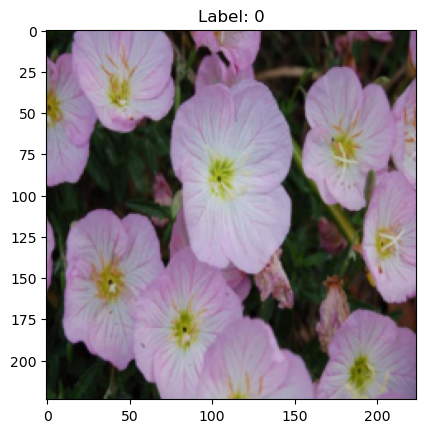

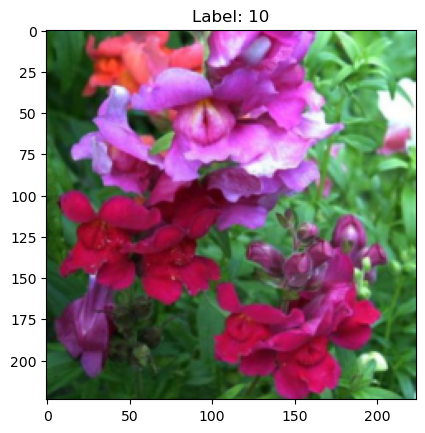

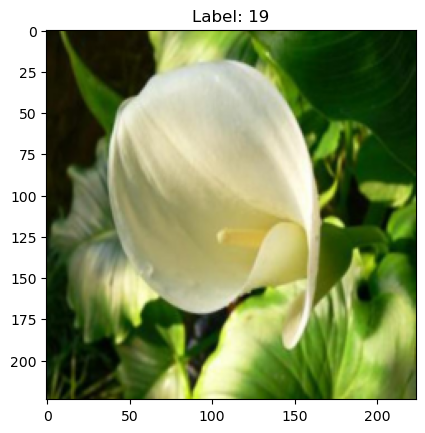

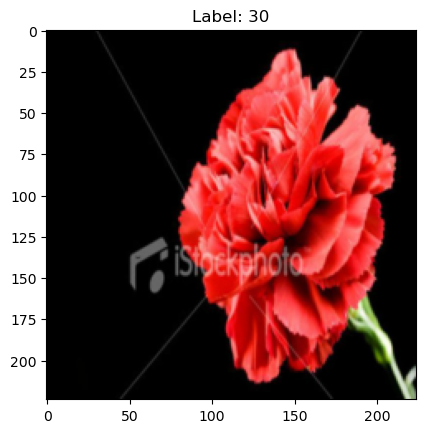

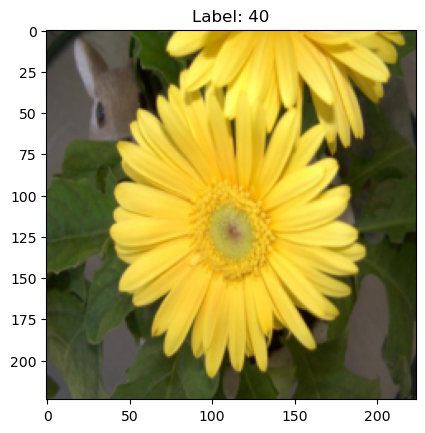

In [6]:
for i in range(5):  # Take example image 0,100,200,300,400
    index = i*100
    curr_f = train_nn[index][0]
    
    #reshape each data form (3, 224, 224) to (224, 224, 3) to plot img correctly 
    reshaped_curr_f = curr_f.permute(1, 2, 0)
    
    curr_lab = train_nn[index][1]
    plt.title("Label: %d" % curr_lab)
    plt.imshow(reshaped_curr_f)
    plt.pause(0.5)

### **Reflection Question (1a):**
In the data exploration stage, what is the purpose of "***assert isinstance(train, Dataset)***"?


**Your Answer:**

To make sure that train_nn is of type from the dataset class to not have any type issues.

## **Part 2: Self-defined CNN**

In this section, you will define your own CNN (convolutional neural network) to classify the Oxford flowers.

Recall from the first problem, to build a neural network using `torch`, we build a class that carries out the functions of the model, define an optimizer, and iterate through a few key steps.

Here, we can make use of [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to save us a little hassle, now that we have seen how to build from the ground up in problem 1.

### Instructions

One suggestion is that you build a model with the following architecture, although you are free to try others as well with the same idea:

1.) Convolution with 3x3 kernel, input shape is the image shape. Make use of [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d), followed by [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU) and [`torch.nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d) with `kernel_size` 2 and `stride` 2

2.) Repeat step 1 (or a couple times), being careful about input shape

3.) Convolution with 3x3 kernel, input shape is the image shape. Make use of [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d), followed by [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU) and [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten)

4.) Fully connected layer using [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear) and [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU)

5.)[`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout)

6.) Linear layer returning us to number of classes (102)

7.) [`nothing`] or [`torch.nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax) to get label likelihood. Remember now that depending on which of these you use, you will need either [`criterion = nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss) or [`criterion = nn.NLLLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss) in training. If you use `nn.CrossEntropyLoss()`, you will need the extra step of calling [`nn.functional.softmax(output, dim=1)`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax) to compare outputs to targets in model evaluation, but not before calculating the loss in your training loop.

After fitting the model, please test the accuracy of the prediction on the test set.

In this stage, we do not ask for a great performance (you should have 'some' predictive performance though). But please ensure that you obtain a trainable model with no programming bugs. You may find it helpful to print the training progress bar or epoch.

In [7]:
# Step 1: Model definition
# Use a nn.Sequential model for deining your own CNN

########## Your code here ##########
# Define the model using nn.Sequential, naming it model


import torch
import torch.nn as nn
import torch.nn.functional as F

class my_model(nn.Module):
    def __init__(self, num_classes=102):
        super(my_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * (224 // 4) ** 2, 512),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = my_model()


In [8]:
# Optional: print a summary of your model
from torchsummary import summary

# Assuming your model_transfer is defined, you can print the summary
summary(model, (3, 224, 224))  # Assuming input size is (3, 224, 224)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
           Flatten-9               [-1, 401408]               0
           Linear-10                  [-1, 512]     205,521,408
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 102]          52,326
Total params: 205,666,982
Trainable par

### Instructions:

Here we will prepare ourselves for training.

We need to define a few things before running our training loop, namely the `DataLoader`, `criterion`, [`optimizer`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), and [`lr_scheduler`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html).

In [9]:
import torch.optim as optim
# Step 2: Model compilation
# Be sure to specify the optimizer, loss and metric as required


# Assuming you have a PyTorch model named 'model'
train_loader_nn = DataLoader(train_nn, batch_size=32, shuffle=True)


# Define your loss function, naming it 'criterion'
########## Your code here ##########
criterion = nn.CrossEntropyLoss() 

# Define your optimizer, 'optimizer' (Adam is suggested)
########## Your code here ##########
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler, 'lr_scheduler' (StepLR is suggested)
########## Your code here ##########
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)



# Define accuracy calculation function
def accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

### Instructions:

Fill in necessary blanks in the training loop, with the provided guidance

In [10]:
# Step 3: Model fitting
# Use the prepared training data to fit your CNN

# Training loop
epochs = 10  # Set the number of training epochs

print("start to train")

for epoch in range(epochs):
    print("epoch " + str(epoch))
    
    model.train()
    
    total_accuracy = 0.0
    
    
    for batch in train_loader_nn:
        inputs, labels = batch
        
        # zero the gradient, calculate outputs, calculate loss,
        # backpropagate, and take a step
        #
        # this should be familiar from earlier problems in the assignment
        
        ########## YOUR CODE HERE ###########
        
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
 
        loss.backward()
        optimizer.step()
        
        
        
        
        # Calculate accuracy for this batch
        
        outputs = nn.functional.softmax(outputs, dim=1) 
        predicted_classes = outputs.argmax(dim=1)
        batch_accuracy = (predicted_classes == labels).float().mean()
        total_accuracy += batch_accuracy.item()
        
    # Calculate the average accuracy for the entire epoch
    average_accuracy = total_accuracy / len(train_loader_nn)
    
    # Take a step in learning rate with 'lr_scheduler`
    
    ############# YOUR CODE HERE ##############
    scheduler.step()
        
    print(f"Epoch {epoch + 1}/5, Loss: {loss.item()}, Accuracy: {average_accuracy * 100:.2f}%")
    print("len train_loader is " + str(len(train_loader_nn)))

start to train
epoch 0
Epoch 1/5, Loss: 4.617739200592041, Accuracy: 1.27%
len train_loader is 32
epoch 1
Epoch 2/5, Loss: 4.6291069984436035, Accuracy: 0.68%
len train_loader is 32
epoch 2
Epoch 3/5, Loss: 4.624783515930176, Accuracy: 0.78%
len train_loader is 32
epoch 3
Epoch 4/5, Loss: 4.628684043884277, Accuracy: 0.78%
len train_loader is 32
epoch 4
Epoch 5/5, Loss: 4.626435279846191, Accuracy: 0.68%
len train_loader is 32
epoch 5
Epoch 6/5, Loss: 4.627529144287109, Accuracy: 0.98%
len train_loader is 32
epoch 6
Epoch 7/5, Loss: 4.628823757171631, Accuracy: 0.78%
len train_loader is 32
epoch 7
Epoch 8/5, Loss: 4.627772808074951, Accuracy: 0.78%
len train_loader is 32
epoch 8
Epoch 9/5, Loss: 4.629915714263916, Accuracy: 0.60%
len train_loader is 32
epoch 9
Epoch 10/5, Loss: 4.627346992492676, Accuracy: 0.78%
len train_loader is 32


In [11]:
# Step 4: Model evaluation
# Use the prepared testing data to evaluate the transfer learning model

test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)

model.eval()  
with torch.no_grad():
    
    test_total_accuracy = 0.0
    
    for test_batch in test_dataloader_nn:
        test_inputs, test_labels = test_batch
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels)       
        
        outputs = nn.functional.softmax(outputs, dim=1) 
        test_predicted_classes = test_outputs.argmax(dim=1)
        test_batch_accuracy = (test_predicted_classes == test_labels).float().mean()
        test_total_accuracy += test_batch_accuracy
        
    test_average_accuracy = test_total_accuracy/len(test_dataloader_nn)
    
    print(f"Test Loss: {test_loss.item()}" + "   Test Accuracy:"
                              + str(round(test_average_accuracy.item()*100,2)) + " %")

    print("len test_loader is " + str(len(test_dataloader_nn)))

Test Loss: 4.6207594871521   Test Accuracy:0.62 %
len test_loader is 193


### **Reflection Questions:**

(1) How did you choose your network structure? \\
(2) Which optimizer did you use? Why? \\

**Your Answer:**

I choose my network structure based on instructions and what it looks to be often used parameters when I searched CNN models online, I used Adam optimizer because is the was suggested and is very reliable.





## **Part 3: Transfer Learning Using Pre-trained Model**

There are several types of transfer learning, as illustrated [here](http://ronny.rest/blog/post_2017_10_13_tf_transfer_learning/). In this homework, you will practice B2, using MobileNet_V2.

### (1) Freeze the pre-trained model and fine-tune the transfer learning.

In [12]:
import torchvision

# Load the pre-trained MobileNetV2 model
MobileNetV2 = torchvision.models.mobilenet_v2(pretrained=True)
MobileNetV2.classifier = nn.Identity()  # Remove the classifier layers

# Set the model to evaluation mode
MobileNetV2.eval()

/opt/anaconda3/envs/columbia_research/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/columbia_research/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Now you can go through the same steps to build and train the transfer learning model.

### Instructions:
Within the `model_transfer = nn.Sequential()` call, dd an Adaptive Average Pooling layer with [`nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d), then perform flattening and apply a linear layer as you should be familiar with from earlier.

As before, remember your choice of whether to use Cross Entropy or Negative Log Likelihood, and make sure to use the corresponding output of your model (i.e., whether to apply Softmax after calculating loss or within the model)

In [13]:
# checking number of features
dummy_input = torch.randn(1, 3, 224, 224)

# Pass the dummy input through the model
with torch.no_grad():
    dummy_output = MobileNetV2(dummy_input)

# Inspect the size of the output
output_size = dummy_output.size(1)  # The size of the second dimension is the number of output features
print(output_size)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


1280


In [14]:
# Step 1: Model definition
# Use a torch.nn Sequential model for defining the transfer learning model (B1 style)

# Set MobileNetV2 parameters to non-trainable
for param in MobileNetV2.parameters():
    param.requires_grad = False


# Use a custom reshape layer
class ReshapeLayer(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1), 1, 1)
    
    
# Create a Sequential model in PyTorch
model_transfer = nn.Sequential(
    MobileNetV2,
    ReshapeLayer(),  # Reshape to [batch_size, num_channels, 1, 1]
    
    
########## Your code here ##########
    nn.AdaptiveAvgPool2d((1, 1)),  
    nn.Flatten(),  
    nn.Linear(output_size, 102)  
    
    
    
)

In [15]:
# define batch size here
batch_size = 32
input_tensor = torch.randn([batch_size, 3, 224, 224])

# visualize the model graphical structure
#Iterate through the model and print the dimensions at each layer
for layer in model_transfer:
    input_tensor = layer(input_tensor)
    print(f"Layer: {layer.__class__.__name__}, Output Shape: {input_tensor.shape}")

Layer: MobileNetV2, Output Shape: torch.Size([32, 1280])
Layer: ReshapeLayer, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: AdaptiveAvgPool2d, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: Flatten, Output Shape: torch.Size([32, 1280])
Layer: Linear, Output Shape: torch.Size([32, 102])


In [16]:
print(model_transfer)

Sequential(
  (0): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), s

### Instructions:

As before, write code to define your `optimizer`, `DataLoader`, `loss (criterion)`, and `lr_scheduler`.

Then, write a training loop.

Your code here should look similar to earlier in the assignment, outside of choosing hyperparameters, names, and possibly choice of loss.

In [17]:
# Step 2: Prepare for training
# Be sure to specify the optimizer, loss, DataLoader, lr_scheduler as before

########## Your code here ##########

import torch.optim as optim

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_transfer.parameters()), lr=0.001)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_nn, batch_size=64, shuffle=True)
test_loader = DataLoader(test_nn, batch_size=64, shuffle=False)



criterion = torch.nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)







# Training loop
epochs = 5

# Step 3: Model fitting
# Use the prepared training data to fit the transfer learning model

########## Your code here ##########


for epoch in range(epochs):
    
    model_transfer.train()
    train_loss = 0.0
    total_accuracy = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_transfer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        outputs = nn.functional.softmax(outputs, dim=1) 
        predicted_classes = outputs.argmax(dim=1)
        batch_accuracy = (predicted_classes == labels).float().mean()
        total_accuracy += batch_accuracy.item()


    average_accuracy = total_accuracy / len(train_loader)
    
    # Take a step in learning rate with 'lr_scheduler`
    
    ############# YOUR CODE HERE ##############
    scheduler.step()
        
    print(f"Epoch {epoch + 1}/5, Loss: {loss.item()}, Accuracy: {average_accuracy * 100:.2f}%")
    print("len train_loader is " + str(len(train_loader_nn)))







Epoch 1/5, Loss: 3.872015953063965, Accuracy: 10.27%
len train_loader is 32
Epoch 2/5, Loss: 2.450422763824463, Accuracy: 63.87%
len train_loader is 32
Epoch 3/5, Loss: 1.5286691188812256, Accuracy: 87.67%
len train_loader is 32
Epoch 4/5, Loss: 1.0033855438232422, Accuracy: 96.28%
len train_loader is 32
Epoch 5/5, Loss: 0.8417075276374817, Accuracy: 97.83%
len train_loader is 32


In [18]:
# Step 3: Model evaluation
# Use the prepared testing data to evaluate the transfer learning model

test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)

print("model_transfer")
model_transfer.eval()  # Set the model to evaluation mode
with torch.no_grad():
    
    test_total_accuracy = 0.0
    
    for test_batch in test_dataloader_nn:
        test_inputs, test_labels = test_batch
        test_outputs = model_transfer(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        
        test_outputs = nn.functional.softmax(test_outputs, dim=1) 
        test_batch_accuracy = accuracy(test_outputs, test_labels)
        test_total_accuracy += test_batch_accuracy
        
    test_average_accuracy = test_total_accuracy/len(test_dataloader_nn)
    
    print(f"Test Loss: {test_loss.item()}" + "   Test Accuracy:" + str(test_average_accuracy*100) + "%")
    print("len test_loader is " + str(len(test_dataloader_nn)))

model_transfer
Test Loss: 0.8472633361816406   Test Accuracy:82.10816062176166%
len test_loader is 193


### (2) Fine-tune some parameters in your network to see if you can improve the performance on testing data. (Optional)

In [19]:
########## Your code here ##########




### **Reflection Questions:**

(1) Briefly explain the network structure of MobileNet and how is it different from other models? \\
(2) In your experiment, which parameter(s) is the network most sensitive to? Can you briefly reason why? \\
(3) What are some pros and cons of doing transfer learning? \\
(4) What is a batch? How does the batch size affect the training process? \\
(5) What is an epoch during the training process?

**Your Answer:** 

MobileNet structure used Conv2d layers similar to our model but it also incorporates Inverted residual blocks which use depth wise separable convolutions and pointwise convolutions which helps improve the efficiency. we have 1 conv2d and 2 inverse residual layers.
In my opinion the learning rate is the parameter on which the network is more sensitie to, this parameter if is too high can cause the network to converge faster to a solution that may not be the best one and if is too low it may cause the training process to be so slow. 
A few pros of transfer learning is that by taking advantage of models are already created, we take less time to train the model, also can improve performance like we saw in this example by using a model that is well established. SOme cons are that there is a risk of overfitting if the dataset is small after the transfer, also some of this models when we transfer them may be very heavy and requires more computational power.
A batch is a small subset of the training data that is used to train the data on each iteration, large batches are bad for memory space while small batches may come with unstable training. 
A epoch is one complete iteration of the training process, this is important since it defines how many times the model will learn.

(2) Describe any observation you find interesting from the above experiment (Open-ended).

**Your Answer:**

is interesting how using a previus model on our data can improve so much the accuracy to the point of being reliable and worth using. The test data accuracy when up drastically by doing the transfer

